In [88]:
%matplotlib widget
%matplotlib inline
import sys
import scipy
import matplotlib.pyplot as plt
from image_utils import *
from utils import Printer
import glob
from stereo_utils import *
from calibration import *
import matplotlib as mpl
from scipy.spatial.transform import Rotation
K =  np.array([[568.996140852, 0 ,643.21055941],
     [0, 568.988362396, 477.982801038],
     [0 ,0,1]])

from get_data import *

import numpy as np
import cv2
import glob
import argparse
import os
from misc_utils import *
from triangulation import *
from tqdm import tqdm
    
def myRANSAC(pts1,pts2,indices):
    n_rows = np.array(pts1).shape[0]
    n = 1000
    thresh = 0.05
    ones = np.ones((pts1.shape[0], 1))
    pts_img1 = np.hstack((pts1, ones))
    pts_img2 = np.hstack((pts2, ones))
    max_inliers = 0
    chosen_indices = []
    for i in tqdm(range(n)):
        
        random = np.random.choice(n_rows,size = 8)
        img1_8pt = pts_img1[random,:]
        img2_8pt = pts_img2[random,:]
        # img1_8pt = np.array([pt + [1] for pt in img1_8pt],dtype=int)
        # img2_8pt = np.array([pt + [1] for pt in img2_8pt],dtype=int)
        F = compute_fundamental_matrix_normalized(img1_8pt,img2_8pt)
        in_a = []
        in_b = []
        ind = []
        update = 0
        
        for i in range(n_rows):
            matches_aa = np.append(pts1[i, :], 1)
            matches_bb = np.append(pts2[i, :], 1)
            error = np.dot(matches_aa, F.T)
            error = np.dot(error, matches_bb.T)
            if abs(error) < 0.005:
                in_a.append(pts1[i, :])
                in_b.append(pts2[i, :])
                ind.append(indices[i])
                update += 1

            if update > max_inliers:
                max_inliers = update
                best_F = F
                inliers_1 = in_a
                inliers_2 = in_b
                inlier_index = ind
        
    inliers_1 = np.array(inliers_1)
    inliers_2 = np.array(inliers_2)
    inlier_index = np.array(inlier_index)
    
    return best_F, inliers_1, inliers_2, inlier_index



"""File to load data from the given files
"""
import numpy as np
import sys

sys.dont_write_bytecode = True

def LoadData(path="Data/"):
    """Main function to load data from files

    Args:
        path (str, optional): Path for input text files

    Returns:
        Mx: List of x coordinates of points
        My: List of y coordinates of points
        M: Binary List of features w.r.t. images
        Color: List of RGB values of each feature
    """
    n_images = 6
    Mx = []
    My = []
    M = []
    Color = []
    for i in range(1, n_images):
        mx = []
        my = []
        m = []
        for j in range(i + 1, n_images + 1):

            x_list, y_list, binary_list, rgb_list = FindCorrespondence(
                i, j, path)

            if (j == i + 1):
                mx = x_list
                my = y_list
                m = binary_list

            else:
                mx = np.hstack((mx, x_list[:, 1].reshape((-1, 1))))
                my = np.hstack((my, y_list[:, 1].reshape((-1, 1))))
                m = np.hstack((m, binary_list[:, 1].reshape((-1, 1))))

        if (i == 1):
            Mx = mx
            My = my
            M = m
            Color = rgb_list

        else:

            mx = np.hstack((np.zeros((mx.shape[0], i - 1)), mx))
            my = np.hstack((np.zeros((my.shape[0], i - 1)), my))
            m = np.hstack((np.zeros((m.shape[0], i - 1)), m))
            assert Mx.shape[1] == mx.shape[1], "SHape not matched"
            Mx = np.vstack((Mx, mx))
            assert My.shape[1] == my.shape[1], "Shape My not matched"
            My = np.vstack((My, my))
            M = np.vstack((M, m))
            Color = np.vstack((Color, rgb_list))
    return Mx, My, M, Color


def FindCorrespondence(a, b, database_path):
    """To extract corrospondance between 2 images from given file

    Args:
        a (int): First Image Number
        b (int): Second Image Number
        database_path (str): path to read file

    Returns:
        list: List of matching points: x,y, binary, rgb
    """
    matching_list = []
    if (1 <= a <= 6):
        with open(database_path + "matching" + str(a) + ".txt") as f:
            line_no = 1
            for line in f:
                if line_no == 1:
                    line_no += 1
                    nfeatures = line[11:15]
                    nfeatures = int(nfeatures)

                else:
                    matching_list.append(line.rstrip('\n'))

    else:
        print("First image argument Number not found")

    final_list = []
    for i in range(0, len(matching_list)):
        current_row = matching_list[i]
        splitStr = current_row.split()
        current_row = []
        for j in splitStr:
            current_row.append(float(j))
        final_list.append(np.transpose(current_row))

    rgb_list = []
    x_list = []
    y_list = []
    binary_list = []
    for i in range(0, len(final_list)):
        rgb_row = []
        x_row = []
        y_row = []
        binary_row = []
        current_row = final_list[i]
        current_row = current_row[1:len(current_row)]

        res = np.where(current_row == b)

        x_row.append(current_row[3])
        y_row.append(current_row[4])
        binary_row.append(1)
        rgb_row.append(current_row[0])
        rgb_row.append(current_row[1])
        rgb_row.append(current_row[2])

        if (len(res[0]) != 0):
            index = res[0][0]
            x_row.append(current_row[index + 1])
            y_row.append(current_row[index + 2])
            binary_row.append(1)

        else:
            x_row.append(0)
            y_row.append(0)
            binary_row.append(0)

        if (len(x_row) != 0):
            x_list.append(np.transpose(x_row))
            y_list.append(np.transpose(y_row))
            binary_list.append(np.transpose(binary_row))
            rgb_list.append(np.transpose(rgb_row))

    return np.array(x_list), np.array(y_list), np.array(binary_list), np.array(
        rgb_list)


def inlier_filter(Mx, My, M, n_images):
    """To filter the binary list for inliers

    Args:
        Mx (array): x coordinates of points
        My (array): y coordinates of points
        M (array): Binary list of features
        n_images (int): Number of images

    Returns:
        TYPE: Corrected List of inliers binary list, Outlier indices
    """
    outlier_indices = np.zeros(M.shape)
    for i in range(1, n_images):
        for j in range(i + 1, n_images + 1):
            img1 = i
            img2 = j

            print("Finding inliers between image " + str(i) + " and " + str(j))
            output = np.logical_and(M[:, img1 - 1], M[:, img2 - 1])
            indices, = np.where(output == True)
            if (len(indices) < 8):
                continue
            # rgb_list = Color[indices]
            pts1 = np.hstack((Mx[indices, img1 - 1].reshape((-1, 1)),
                              My[indices, img1 - 1].reshape((-1, 1))))
            pts2 = np.hstack((Mx[indices, img2 - 1].reshape((-1, 1)),
                              My[indices, img2 - 1].reshape((-1, 1))))

            _, inliers_a, inliers_b, inlier_index = myRANSAC(np.float32(pts1), np.float32(pts2), indices)
            assert len(inliers_a) == len(inliers_b) == len(
                inlier_index), "Length not matched"
            print("Inliers found :" + str(len(inliers_a)) + "/" +
                  str(len(pts1)))
            for k in indices:
                if (k not in inlier_index):
                    M[k, i - 1] = 0
                    outlier_indices[k, i - 1] = 1
                    outlier_indices[k, j - 1] = 1
    return M, outlier_indices



def DrawCorrespondence(i, j, inliers_a, inliers_b, outlier1, outlier2,DrawOutliers):
    """Function to draw correspondences on input image

    Args:
        i (int): Input1 image number
        j (int): Input2 image number
        inliers_a (TYPE): list of inliers in image1
        inliers_b (TYPE): list of inliers in image2
        outlier1 (TYPE): list of outiers in image1
        outlier2 (TYPE): list of outiers in image2
        DrawOutliers (TYPE): Bool to draw outliers

    Returns:
        TYPE: image
    """
    img1 = cv2.imread('Data/' + str(i) + '.jpg')
    img2 = cv2.imread('Data/' + str(j) + '.jpg')

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    out = np.zeros((max([rows1, rows2]), cols1 + cols2, 3), dtype='uint8')
    out[:rows1, :cols1, :] = img1
    out[:rows2, cols1:cols1 + cols2, :] = img2
    radius = 4
    BLUE = (255, 0, 0)
    GREEN = (0, 255, 0)
    RED = (0, 0, 255)
    thickness = 1

    assert len(inliers_a) == len(inliers_b), "inliers in images not equal"
    for m in range(0, len(inliers_a)):
        # Draw small circle on image 1
        cv2.circle(out, (int(inliers_a[m][0]), int(inliers_a[m][1])), radius,
                   RED, -1)

        # Draw small circle on image 2
        cv2.circle(out, (int(inliers_b[m][0]) + cols1, int(inliers_b[m][1])),
                   radius, GREEN, -1)

        # Draw line connecting circles
        cv2.line(out, (int(inliers_a[m][0]), int(inliers_a[m][1])),
                 (int(inliers_b[m][0]) + cols1, int(inliers_b[m][1])), GREEN,
                 thickness)
    if (DrawOutliers):
        assert len(outlier1) == len(outlier2), "outliers in images not equal"
        print("Length of outliers to plot" + str(len(outlier1)))
        for n in range(0, len(outlier1)):
            # Draw small circle on image 1
            cv2.circle(out, (int(outlier1[n][0]), int(outlier1[n][1])), radius,
                       BLUE, -1)

            # Draw small circle on image 2
            cv2.circle(out, (int(outlier2[n][0]) + cols1, int(outlier2[n][1])),
                       radius, BLUE, -1)

            # Draw line connecting circles
            cv2.line(out, (int(outlier1[n][0]), int(outlier1[n][1])),
                     (int(outlier2[n][0]) + cols1, int(outlier2[n][1])), RED,
                     thickness)

    return out


In [89]:
img_list_col = []
img_list = []
img_name_list = []
for name in glob.glob("./Data/*.jpg"):
    img_name_list.append(name)
img_name_list = sorted(img_name_list)
print(img_name_list)
for name in img_name_list:
    img_list.append(img2gray(read_img(name))) 
    img_list_col.append(read_img(name))
    
    

['./Data/1.jpg', './Data/2.jpg', './Data/3.jpg', './Data/4.jpg', './Data/5.jpg', './Data/6.jpg']


In [90]:
Mx, My, M, Color = LoadData("./Data/")
M, outlier_indices = inlier_filter(Mx, My, M, len(img_list))
np.save('M', M)

Finding inliers between image 1 and 2


100%|██████████| 1000/1000 [00:06<00:00, 143.17it/s]


Inliers found :1253/1426
Finding inliers between image 1 and 3


100%|██████████| 1000/1000 [00:02<00:00, 350.88it/s]


Inliers found :494/597
Finding inliers between image 1 and 4


100%|██████████| 1000/1000 [00:02<00:00, 469.11it/s]


Inliers found :380/446
Finding inliers between image 1 and 5
Finding inliers between image 1 and 6
Finding inliers between image 2 and 3


100%|██████████| 1000/1000 [00:09<00:00, 104.68it/s]


Inliers found :1806/2053
Finding inliers between image 2 and 4


100%|██████████| 1000/1000 [00:04<00:00, 205.44it/s]


Inliers found :872/1033
Finding inliers between image 2 and 5
Finding inliers between image 2 and 6
Finding inliers between image 3 and 4


100%|██████████| 1000/1000 [00:10<00:00, 92.15it/s]


Inliers found :2191/2296
Finding inliers between image 3 and 5


100%|██████████| 1000/1000 [00:04<00:00, 217.38it/s]


Inliers found :832/966
Finding inliers between image 3 and 6


100%|██████████| 1000/1000 [00:02<00:00, 468.58it/s]


Inliers found :369/442
Finding inliers between image 4 and 5


100%|██████████| 1000/1000 [00:10<00:00, 97.37it/s]


Inliers found :2048/2166
Finding inliers between image 4 and 6


100%|██████████| 1000/1000 [00:05<00:00, 183.00it/s]


Inliers found :1027/1146
Finding inliers between image 5 and 6


100%|██████████| 1000/1000 [00:09<00:00, 106.92it/s]


Inliers found :1763/1971


In [91]:

M = np.load('M.npy')

In [92]:
img1 = 1
img2 = 4

recon_bin = np.zeros((M.shape[0], 1))
X_3D = np.zeros((M.shape[0], 3))

#  We have all inliers at this point in M
output = np.logical_and(M[:, img1 - 1], M[:, img2 - 1])
outlier = np.logical_and(outlier_indices[:, img1 - 1],
                            outlier_indices[:, img2 - 1])
outlier_idx = np.where(outlier == True)
indices, = np.where(output == True)
rgb_list = Color[indices]

pts1 = np.hstack((Mx[indices, img1 - 1].reshape((-1, 1)),
                    My[indices, img1 - 1].reshape((-1, 1))))
pts2 = np.hstack((Mx[indices, img2 - 1].reshape((-1, 1)),
                    My[indices, img2 - 1].reshape((-1, 1))))

In [93]:
ones = np.ones((pts1.shape[0], 1))
pts_img1 = np.hstack((pts1, ones))
pts_img2 = np.hstack((pts2, ones))
best_F = compute_fundamental_matrix_normalized(np.float32(pts_img1), np.float32(pts_img2))

outlier1 = np.hstack((Mx[outlier_idx, img1 - 1].reshape((-1, 1)),
                        My[outlier_idx, img1 - 1].reshape((-1, 1))))
outlier2 = np.hstack((Mx[outlier_idx, img2 - 1].reshape((-1, 1)),
                        My[outlier_idx, img2 - 1].reshape((-1, 1))))

Length of outliers to plot73


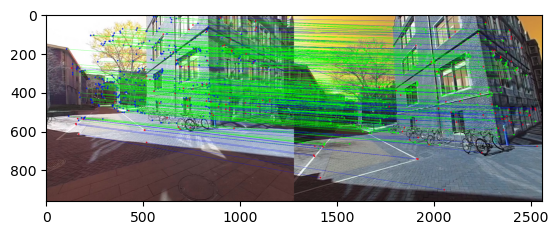

In [94]:
if (True):
    out = DrawCorrespondence(img1, img2, pts1, pts2, outlier1, outlier2, DrawOutliers=True)
    plt.imshow(out)

In [95]:
F = best_F
K1 = K
K2 = K
E = np.dot(K2.T, np.dot(F,K1))
print("Essential Matrix:")
Printer.green(E)

Printer.purple("My method:")
W = np.mat([[0,-1,0],[1,0,0],[0,0,1]],dtype=float)
U,d,Vt = np.linalg.svd(E)
if np.linalg.det(U) < 0:
    U *= -1.0
if np.linalg.det(Vt) < 0:
    Vt *= -1.0
R = np.dot(np.dot(U, W), Vt)
if np.sum(R.diagonal()) < 0:
    R = np.dot(np.dot(U, W.T), Vt)
t = U[:, 2]
ret = np.eye(3,4)
ret[:3,:3]= R
ret[:3,3]= t
print(ret)
Printer.green(R)
Printer.cyan(t)
np.linalg.det(Vt)
    
def ExtractCameraPose(E, K):
    """
    Args:
        E (array): Essential Matrix
        K (array): Intrinsic Matrix

    Returns:
        arrays: set of Rotation and Camera Centers
    """
    U, S, V_T = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    # print("E svd U", U)
    # print("E svd S", S)
    # print("E svd U[:, 2]", U[:, 2])
    R = []
    C = []
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    C.append(U[:, 2])
    C.append(-U[:, 2])
    C.append(U[:, 2])
    C.append(-U[:, 2])

    for i in range(4):
        if (np.linalg.det(R[i]) < 0):
            R[i] = -R[i]
            C[i] = -C[i]

    return R, C

R_set, C_set = ExtractCameraPose(E, K)


Essential Matrix:
 [[-0.10609573  1.593435    0.07731246]
 [-1.70718053  0.12245204 -1.81087148]
 [ 0.03008948  1.91815384  0.26181353]]
 My method:
[[ 0.99568947  0.07299754 -0.05721745 -0.76971923]
 [-0.06466704  0.98860584  0.1359289   0.05903898]
 [ 0.06648798 -0.1316429   0.98906496  0.63564668]]
 [[ 0.99568947  0.07299754 -0.05721745]
 [-0.06466704  0.98860584  0.1359289 ]
 [ 0.06648798 -0.1316429   0.98906496]]
 [-0.76971923  0.05903898  0.63564668]


In [96]:
X_set = []
color = ['r', 'g', 'b', 'k']

for n in range(0, 4):
    X1 = LinearTriangulation(K, np.zeros((3, 1)), np.identity(3),
                                C_set[n].T, R_set[n], np.float32(pts1),
                                np.float32(pts2))
    X_set.append(X1)

X, R, C = DisambiguateCameraPose(C_set, R_set, X_set)

In [97]:
recon_bin = np.zeros((M.shape[0], 1))
X_3D = np.zeros((M.shape[0], 3))
Visibility = np.zeros((M.shape[0], len(img_list)))

X = NonLinearTriangulation(K, np.float32(pts1), np.float32(pts2), X,
                            np.eye(3), np.zeros((3, 1)), R, C)

recon_bin[indices] = 1
X_3D[indices, :] = X
Visibility[indices, img1 - 1] = 1
Visibility[indices, img2 - 1] = 1

In [98]:
""" File to implement Non Linear PnP method
"""
import numpy as np
import scipy.optimize as opt
from scipy.spatial.transform import Rotation as Rscipy
import random
from tqdm import tqdm
import math
import numpy as np
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares
import sys

def convertHomogeneouos(x):
    """Summary
    Args:
        x (array): 2D or 3D point
    Returns:
        TYPE: point appended with 1
    """
    m, n = x.shape
    ones = np.ones((m, 1))
    if (n == 3 or n == 2):
        x_new = np.hstack((x,ones))
    else:
        x_new = x
    return x_new


def LinearPnP(X, x, K):
    """Summary
    Args:
        X (TYPE): 3D points
        x (TYPE): 2D points
        K (TYPE): intrinsic Matrix
    Returns:
        TYPE: C_set, R_set
    """
    N = X.shape[0]
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    x = np.hstack((x, np.ones((x.shape[0], 1))))
    # x = (kinv.x')'
    x = np.transpose(np.dot(np.linalg.inv(K), x.T))
    A = []
    for i in range(N):
        xt = X[i, :].reshape((1, 4))
        z = np.zeros((1, 4))
        p = x[i, :]  #.reshape((1, 3))
        a1 = np.hstack((np.hstack((z, -xt)), p[1] * xt))
        a2 = np.hstack((np.hstack((xt, z)), -p[0] * xt))
        a3 = np.hstack((np.hstack((-p[1] * xt, p[0] * xt)), z))
        a = np.vstack((np.vstack((a1, a2)), a3))

        if (i == 0):
            A = a
        else:
            A = np.vstack((A, a))

    _, _, v = np.linalg.svd(A)
    P = v[-1].reshape((3, 4))
    R = P[:, 0:3]
    t = P[:, 3]
    u, _, v = np.linalg.svd(R)

    R = np.matmul(u, v)
    d = np.identity(3)
    d[2][2] = np.linalg.det(np.matmul(u, v))
    R = np.dot(np.dot(u, d), v)
    C = -np.dot(np.linalg.inv(R), t)
    if np.linalg.det(R) < 0:
        R = -R
        C = -C
    return C, R


def proj3Dto2D(x3D, K, C, R):
    """Summary
    Args:
        x3D (TYPE): Description
        K (TYPE): Description
        C (TYPE): Description
        R (TYPE): Description
    Returns:
        TYPE: Description
    """
    C = C.reshape(-1, 1)
    x3D = x3D.reshape(-1, 1)
    # print("K", K.shape, R.shape, C.shape, x3D.shape)
    P = np.dot(np.dot(K, R), np.hstack((np.identity(3), -C)))
    X3D = np.vstack((x3D, 1))

    # print("P",P.shape, X3D.shape)
    u_rprj = (np.dot(P[0, :], X3D)).T / (np.dot(P[2, :], X3D)).T
    v_rprj = (np.dot(P[1, :], X3D)).T / (np.dot(P[2, :], X3D)).T
    X2D = np.hstack((u_rprj, v_rprj))
    return X2D

def PnPRANSAC(X, x, K):
    """
    args:
        X (TYPE): 3d points
        x (TYPE): 2d points
        K (TYPE): camera matrix
    return:
        TYPE: translation, rotation matrix
    """
    cnt = 0
    M = x.shape[0]
    threshold = 5  #6
    xhomo = convertHomogeneouos(x)
    Cnew = np.zeros((3, 1))
    Rnew = np.identity(3)
    for trails in tqdm(range(500)):
        # random.randrange(0, len(corr_list))
        random_idx = random.sample(range(M), 6)
        C, R = LinearPnP(X[random_idx][:], x[random_idx][:], K)
        S = []
        for j in range(M):
            reprojection = proj3Dto2D(xhomo[j][:], K, C, R)
            e = np.sqrt(
                np.square((xhomo[j, 0]) - reprojection[0]) +
                np.square((xhomo[j, 1]) - reprojection[1]))
            if e < threshold:
                S.append(j)
        countS = len(S)
        if (cnt < countS):
            cnt = countS
            Rnew = R
            Cnew = C

        if (countS == M):
            break
    # print("Inliers = " + str(cnt) + "/" + str(M))
    return Cnew, Rnew


def reprojError(CQ, K, X, x):
    """Function to calculate reprojection error
    args:
        K (TYPE): cam matrix
        X (TYPE): 3d pts
        x (TYPE): 2d pts

    return:
        TYPE: reprojection error
    """
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    C = CQ[0:3]
    R = CQ[3:7]
    C = C.reshape(-1, 1)
    r_temp = Rscipy.from_quat([R[0], R[1], R[2], R[3]])
    R = r_temp.as_matrix()
    P = np.dot(np.dot(K, R), np.hstack((np.identity(3), -C)))
    u_reproj = (np.dot(P[0, :], X.T)).T / (np.dot(P[2, :], X.T)).T
    v_reproj = (np.dot(P[1, :], X.T)).T / (np.dot(P[2, :], X.T)).T
    e1 = x[:, 0] - u_reproj
    e2 = x[:, 1] - v_reproj
    e = e1 + e2
    return sum(e)


def NonLinearPnP(X, x, K, C0, R0):
    q_temp = Rscipy.from_matrix(R0)
    Q0 = q_temp.as_quat()
    CQ = [C0[0], C0[1], C0[2], Q0[0], Q0[1], Q0[2], Q0[3]]
    assert len(CQ) == 7, "length of init in nonlinearpnp not matched"
    optimized_param = opt.least_squares(fun=reprojError, method="dogbox",x0=CQ,args=[K, X, x])
    Cnew = optimized_param.x[0:3]
    assert len(Cnew) == 3, "Translation Nonlinearpnp error"
    R = optimized_param.x[3:7]
    r_temp = Rscipy.from_quat([R[0], R[1], R[2], R[3]])
    Rnew = r_temp.as_matrix()
    return Cnew, Rnew

def BuildVisibilityMatrix(Visibility, r_indx, print_enable=False):
    """To return Visibility matrix element
    Args:
        Visibility (array): Visibility Matrix
        r_indx (images): Index of images
        print_enable (bool, optional): To print the returning element

    Returns:
        TYPE: Element of matrix
    """
    if (print_enable):
        print(Visibility[:, r_indx])

    return Visibility[:, r_indx]



def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    Rodrigues' rotation formula is used.
    Args:
        points (array): points to rotate
        rot_vecs (TYPE): rotation vector
    Returns:
        TYPE: rotated points
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:,np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v


def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images.

    Args:
        points (array): 2D points
        camera_params (array): Intrinsic paramters matrix

    Returns:
        TYPE: Projected 3D points
    """
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj


def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    `params` contains camera parameters and 3-D coordinates.
    Args:
        params (TYPE): camera parameters and 3D coordinates
        n_cameras (TYPE): number of cameras
        n_points (TYPE): total number of points
        camera_indices (TYPE): indexes of camera in which point is visibles
        point_indices (TYPE): indices of input points
        points_2d (TYPE): 2D input points
    Returns:
        TYPE: Difference between projected and 2D points
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices],
                          camera_params[camera_indices])
    return (points_proj - points_2d).ravel()


def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices,point_indices):
    """Computes Bundle Adustment for the computed SFM results
    Args:
        n_cameras (int): Number of Cameras(6)
        n_points (int): Number of total Points
        camera_indices (array): indices of visible cameras
        point_indices (array): indices of visible points
    Returns:
        TYPE: Sparse output Adjustment
    """
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1
    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A


def BundleAdjustment(Cset, Rset, X, K, points_2d, camera_indices, recon_bin,
                     V_bundle):
    """
    Args:
        Cset (TYPE): Set of all camera centers
        Rset (TYPE): Set of all Rotation Matrices
        X (TYPE): array of 3D points
        K (TYPE): intrinsic matrix
        points_2d (TYPE): 2D points
        V_bundle (TYPE): Visibility Matrix
    Returns:
        TYPE: Corrected R_set, C_set, X
    """
    f = K[1, 1]
    camera_params = []
    # camera_indices  = np.array(r_indx[1:])
    point_indices, _ = np.where(recon_bin == 1)
    V = V_bundle[point_indices, :]
    points_3d = X[point_indices, :]
    for C0, R0 in zip(Cset, Rset):
        q_temp = Rscipy.from_matrix(R0)
        Q0 = q_temp.as_rotvec()
        params = [Q0[0], Q0[1], Q0[2], C0[0], C0[1], C0[2], f, 0, 0]
        camera_params.append(params)

    camera_params = np.reshape(camera_params, (-1, 9))
    n_cameras = camera_params.shape[0]
    assert len(Cset) == n_cameras, "length not matched"
    n_points = points_3d.shape[0]
    n = 9 * n_cameras + 3 * n_points
    m = 2 * points_2d.shape[0]
    print("n_cameras: {}".format(n_cameras))
    print("n_points: {}".format(n_points))
    print("Total number of parameters: {}".format(n))
    print("Total number of residuals: {}".format(m))
    opt = True
    # opt = False
    # print(point_indices.shape)
    # print(camera_indices.shape)
    # print(points_3d.shape)
    # print(points_2d.shape)

    if (opt):
        A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices,
                                       point_indices)
        # print(camera_params.ravel)
        x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
        res = least_squares(
            fun,
            x0,
            jac_sparsity=A,
            verbose=2,
            x_scale='jac',
            ftol=1e-4,
            method='trf',
            args=(n_cameras, n_points, camera_indices, point_indices,
                  points_2d))

        parameters = res.x
        camera_p = np.reshape(parameters[0:camera_params.size], (n_cameras, 9))
        X = np.reshape(parameters[camera_params.size:], (n_points, 3))
        for i in range(n_cameras):
            Q0[0] = camera_p[i, 0]
            Q0[1] = camera_p[i, 1]
            Q0[2] = camera_p[i, 2]
            C0[0] = camera_p[i, 2]
            C0[1] = camera_p[i, 2]
            C0[2] = camera_p[i, 6]
            r_temp = Rscipy.from_rotvec([Q0[0], Q0[1], Q0[2]])
            Rset[i] = r_temp.as_matrix()
            Cset[i] = [C0[0], C0[1], C0[2]]

    return Rset, Cset, X




# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R):
    """To check if the matrix id rotation matrix

    Args:
        R (TYPE): Input matrix

    Returns:
        TYPE: Norm of image
    """
    Rt = np.transpose(R)

    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


# Calculates rotation matrix to euler angles
def rotationMatrixToEulerAngles(R):
    """Convert Rotation Matrix to Euler angless

    Args:
        R (TYPE): Rotation Matrix

    Returns:
        TYPE: Angles x,y,z in radians
    """
    assert (isRotationMatrix(R))

    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

    singular = sy < 1e-6

    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])


def DrawCameras(C_set, R_set):
    """To Draw Camera poses on the plot

    Args:
        C_set (TYPE): Set of all camera centers
        R_set (TYPE): Set of all rotation matrices
    """
    for i in range(0, len(C_set)):
        R1 = rotationMatrixToEulerAngles(R_set[i])
        R1 = np.rad2deg(R1)
        plt.plot(
            C_set[i][0],
            C_set[i][2],
            marker=(3, 0, int(R1[1])),
            markersize=15,
            linestyle='None')

100%|██████████| 500/500 [00:02<00:00, 188.48it/s]


n_cameras: 2
n_points: 1060
Total number of parameters: 3198
Total number of residuals: 2120
1 Skiiping this frame


100%|██████████| 500/500 [00:00<00:00, 530.45it/s]
/Users/vishalgattani/miniconda3/lib/python3.9/site-packages/numpy/lib/type_check.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  type_ = asarray(x).dtype.type
/Users/vishalgattani/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


n_cameras: 3
n_points: 1930
Total number of parameters: 5817
Total number of residuals: 3860


100%|██████████| 500/500 [00:02<00:00, 198.96it/s]


n_cameras: 4
n_points: 4299
Total number of parameters: 12933
Total number of residuals: 8598


100%|██████████| 500/500 [00:04<00:00, 111.07it/s]


n_cameras: 5
n_points: 7502
Total number of parameters: 22551
Total number of residuals: 15004


100%|██████████| 500/500 [00:12<00:00, 40.48it/s]


n_cameras: 6
n_points: 8030
Total number of parameters: 24144
Total number of residuals: 16060


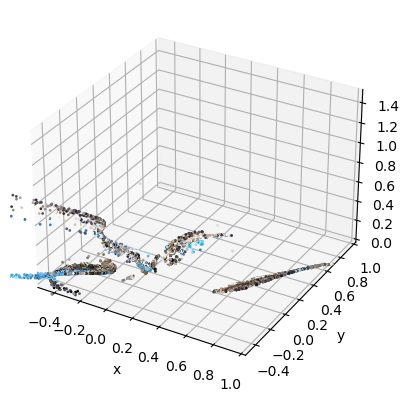

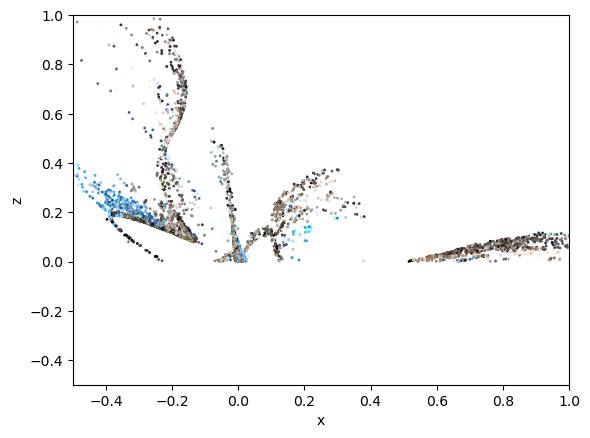

In [99]:
Cset = []
Rset = []

Cset.append(C)
Rset.append(R)

r_indx = [img1, img2]

for i in range(0, len(img_name_list)):

    if (np.isin(r_indx, i)[0]):
        print(i, "Skiiping this frame")
        continue

    output = np.logical_and(recon_bin, M[:, i].reshape((-1, 1)))
    # print(output.shape)
    indices, _ = np.where(output == True)
    #     print("type indices",type(indices))
    if (len(indices) < 8):
        continue

#     print("M",My[indices,i].reshape((-1,1)))
    x = np.transpose([Mx[indices, i], My[indices, i]])
    X = X_3D[indices, :]

    C, R = PnPRANSAC(X, x, K)
    # print(C)
    # print(R)

    C, R = NonLinearPnP(X, x, K, C, R)
    # print(C)
    # print(R)

    Cset.append(C)
    Rset.append(R)
    r_indx.append(i)
    Visibility[indices, i] = 1
    for j in range(0, len(r_indx) - 1):
        output = np.logical_and(
            np.logical_and(1 - recon_bin, M[:, r_indx[j]].reshape(
                (-1, 1))), M[:, i].reshape((-1, 1)))
        indices, _ = np.where(output == True)
        if (len(indices) < 8):
            continue

        x1 = np.hstack((Mx[indices, r_indx[j]].reshape((-1, 1)),
                        My[indices, r_indx[j]].reshape((-1, 1))))
        x2 = np.hstack((Mx[indices, i].reshape((-1, 1)),
                        My[indices, i].reshape((-1, 1))))

        X = LinearTriangulation(K, Cset[j], Rset[j], C, R, x1, x2)

        # X = NonLinearTriangulation(K, x1, x2, X, Rset[j],Cset[j],R,C);
        X_3D[indices, :] = X
        recon_bin[indices] = 1
        Visibility[indices, r_indx[j]] = 1
        Visibility[indices, j] = 1

    for o in range(len(X_3D)):
        if (X_3D[o, 2] < 0):
            Visibility[o, :] = 0
            recon_bin[o] = 0
            
    V_bundle = BuildVisibilityMatrix(Visibility, r_indx)

    point_indices, _ = np.where(recon_bin == 1)
    camera_indices = i * np.ones((len(point_indices), 1))

    points_2d = np.hstack((Mx[point_indices, i].reshape((-1, 1)),
                            Mx[point_indices, i].reshape((-1, 1))))
    
    Rset, Cset, X_3D = BundleAdjustment(Cset, Rset, X_3D, K, points_2d,
                                            camera_indices, recon_bin,
                                            V_bundle)

ind, _ = np.where(recon_bin == 1)
X_3D = X_3D[ind, :]
Color = Color[ind, :]
# For 3D plotting
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(
    X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=Color / 255.0,
    s=1)  # cmap='viridis',
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-0.5, 1])
ax.set_ylim([-0.5, 1])
ax.set_zlim([0, 1.5])

plt.show()

# For 2D plotting

plt.scatter(X_3D[:, 0], X_3D[:, 2], c=Color / 255.0, s=1)
DrawCameras(C_set, R_set)
ax1 = plt.gca()
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
# ax.set_xlim([-0.5, 1])
# ax.set_ylim([-0.5, 2])

plt.show()